# Step-by-step MNIST Digits Classification - Convolutional Neural Networks

1. Load dataset, explore it (display images, mean, min, max values, etc.) and split it into train, validation and test sets
2. Data scaling
3. One hot encoding
4. Define your model, cost function, optimizer, learning rate
5. Define your callbacks (save your model, patience, etc.)
6. Train your model
    
    6.1 If you are satisfied with the train and validation performance go to the next step
    
    6.2 If you are not satisfied with the train and validation performance go back to step 5
7. Test your model on the test and extract relevant metrics

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load dataset, explore it  and split it into train, validation and test sets

- [Load MNIST Keras](https://keras.io/api/datasets/mnist/#load_data-function)

In [2]:
# Loading the data using the Keras function
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.mnist.load_data() # The data comes already split 
                                                                        # in dev and test sets
print("Development set")
print("Images: ",X_dev.shape)
print("Labels shape:",Y_dev.shape)
print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)

Development set
Images:  (60000, 28, 28)
Labels shape: (60000,)

Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Test set
Images:  (10000, 28, 28)
Labels shape:  (10000,)


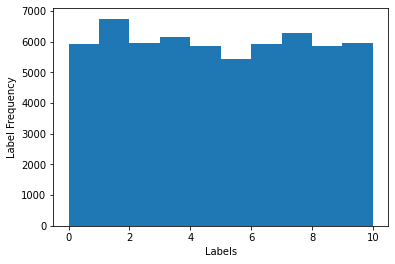

In [3]:
plt.figure()
plt.hist(Y_dev, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

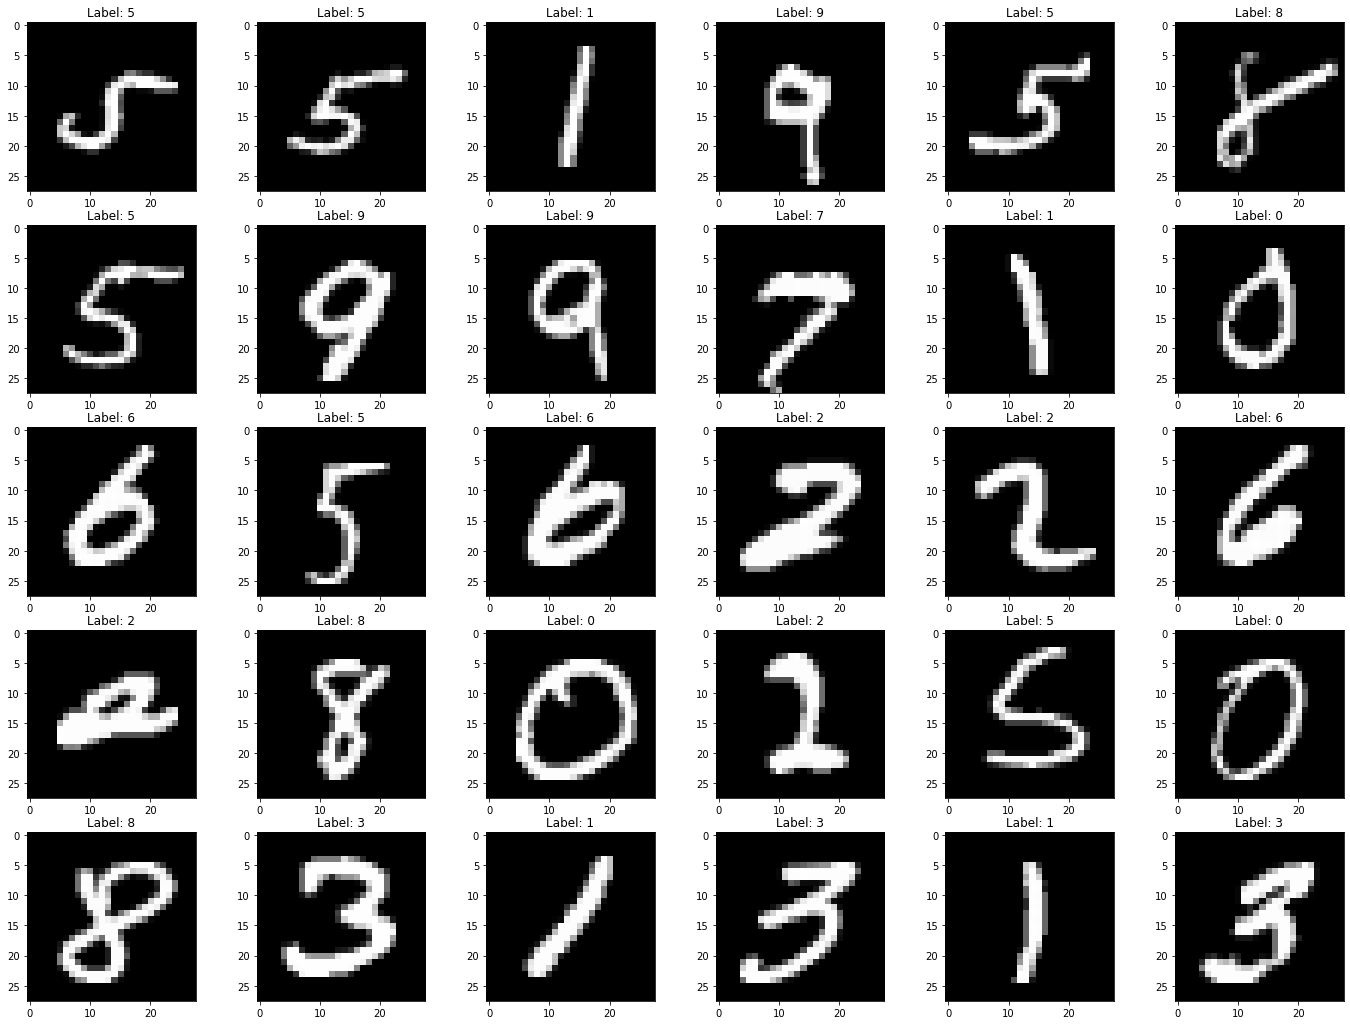

In [4]:
# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [5]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (45000, 28, 28)
Labels shape:  (45000,)

Validation set
Images:  (15000, 28, 28)
Labels shape:  (15000,)


In [6]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 33.29481490929705 78.541712904855
0 255 33.38924107142857 78.64472801055584


## 2. Data Scaling 

In [7]:
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

## 3. One hot encoding

In [8]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[3 5 0 6 3]

One hot encoded labels:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## 4. Define your model, cost function, optimizer, learning rate

In [9]:
def my_model(ishape = (28,28,1),k = 10, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    l1 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(model_input)
    l2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)
    l4 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l3)
    l5 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    flat = tf.keras.layers.Flatten()(l5_drop)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [10]:
model = my_model()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 48)        480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 48)        20784     
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 48)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 96)        41568     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 96)        83040 

## 5. Define your callbacks (save your model, patience, etc.)

- [Keras callbacks](https://keras.io/api/callbacks/)

In [11]:
model_name = "best_model_mnist_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 6. Train your model

In [12]:
model.fit(X_train[:,:,:,np.newaxis],Y_train_oh,batch_size = 32, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val[:,:,:,np.newaxis],Y_val_oh))

Epoch 1/1000
1407/1407 [==============================] - 9s 6ms/step - loss: 0.4151 - accuracy: 0.8834 - val_loss: 0.1801 - val_accuracy: 0.9536 - lr: 5.0000e-05
Epoch 2/1000
1407/1407 [==============================] - 10s 7ms/step - loss: 0.1235 - accuracy: 0.9630 - val_loss: 0.1032 - val_accuracy: 0.9710 - lr: 5.0000e-05
Epoch 3/1000
1407/1407 [==============================] - 10s 7ms/step - loss: 0.0836 - accuracy: 0.9750 - val_loss: 0.0844 - val_accuracy: 0.9758 - lr: 5.0000e-05
Epoch 4/1000
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0675 - accuracy: 0.9797 - val_loss: 0.0715 - val_accuracy: 0.9796 - lr: 5.0000e-05
Epoch 5/1000
 212/1407 [===>..........................] - ETA: 7s - loss: 0.0496 - accuracy: 0.9853

KeyboardInterrupt: 

## 7. Test your model on the test and extract relevant metrics

In [13]:
model.load_weights(model_name)
metrics = model.evaluate(X_test[:,:,:,np.newaxis],Y_test_oh)
print("Categorical cross-entropy:", metrics[0])
print("Accuracy:", metrics[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0585 - accuracy: 0.9837
Categorical cross-entropy: 0.05848461762070656
Accuracy: 0.9836999773979187


163


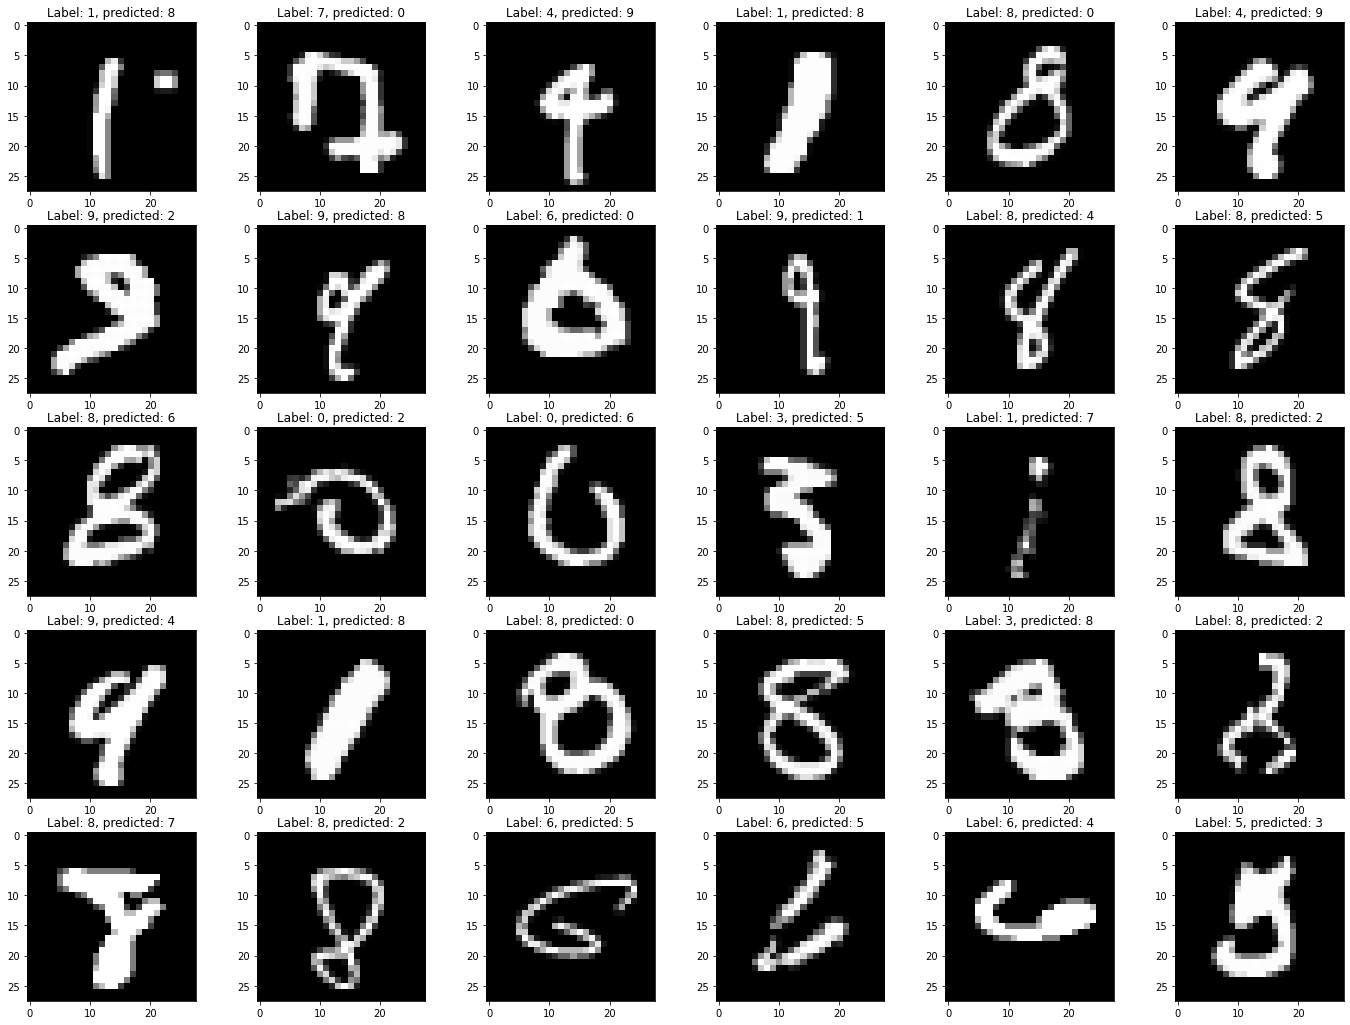

In [14]:
Ypred = model.predict(X_test[:,:,:,np.newaxis]).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()